Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
#Leo el dataset
df = pd.read_csv('amz_uk_price_prediction_dataset.csv')

Part 1: Analyzing Best-Seller Trends Across Product Categories

1. Crosstab Analysis:

- Create a crosstab between the product category and the isBestSeller status.
- Are there categories where being a best-seller is more prevalent?

In [3]:
#Creo la crosstab con la Category y el isBestSeller
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])
crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [4]:
#Calculo la porcion de best-sellers en cada categoria y ordeno por descendiente
crosstab_result['BestSellerProportion'] = crosstab_result[True] / (crosstab_result[True] + crosstab_result[False])
sorted_categories = crosstab_result.sort_values(by='BestSellerProportion', ascending=False)
sorted_categories

isBestSeller,False,True,BestSellerProportion
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
...,...,...,...
"CD, Disc & Tape Players",8798,0,0.000000
General Music-Making Accessories,259,0,0.000000
Snowboard Boots,1449,0,0.000000


2. Statistical Tests:

- Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
- Compute Cramér's V to understand the strength of association between best-seller status and category.

In [5]:
#Chi-square Test
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

print('chi-square:', chi2_statistic)
print('p-value:',chi2_p_value)

chi-square: 36684.23786636857
p-value: 0.0


Los datos proporcionan evidencia estadística para decir que best-seller está relacionado de manera significativa con la categoría de productos. Esto podría significar que ciertas categorías de productos tienen más probabilidades de convertirse en best-sellers que otras.

In [6]:
# Compute Cramér's V
n = crosstab_result.sum().sum()
phi2 = chi2_statistic / n
r, k = crosstab_result.shape
cramers_v = np.sqrt(phi2 / min((r - 1), (k - 1)))

print("Cramér's V:", cramers_v)

Cramér's V: 0.08663731815334759


Esto podría implicar que la categoría de productos no es el único factor determinante en si un producto se convierte en un best-seller, y que otros factores también pueden estar en juego.

3. Visualizations:

- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

<Axes: xlabel='category'>

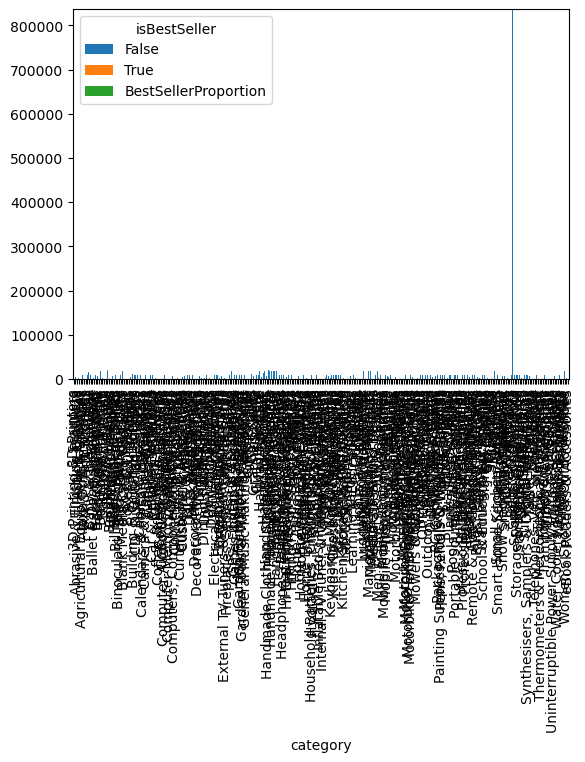

In [7]:
#Bar Chart
crosstab_result.plot(kind="bar", stacked=True)

Part 2: Exploring Product Prices and Ratings Across Categories and Brands

Preliminary Step: Remove outliers in product prices.

In [8]:
#Calculo el IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

In [9]:
#Establezco los límites de los outliers
lower_bounds = Q1 - 1.5 * IQR
upper_bounds = Q3 + 1.5 * IQR

In [26]:
#Identifico y elimino los outliers
df_sin_outliers = df[(df['price'] >= lower_bounds) & (df['price'] <= upper_bounds)]
df_sin_outliers.head(2)


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers


1. Violin Plots:

- Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
- Which product category tends to have the highest median price? Don't filter here by top categories.

In [27]:
#Filtro por las top 20 categorias
category_frequency = df_sin_outliers['category'].value_counts().sort_values()

top_category_frequency = category_frequency.head(20)

df_top_categories = df_sin_outliers[df_sin_outliers['category'].isin(top_category_frequency.index)]

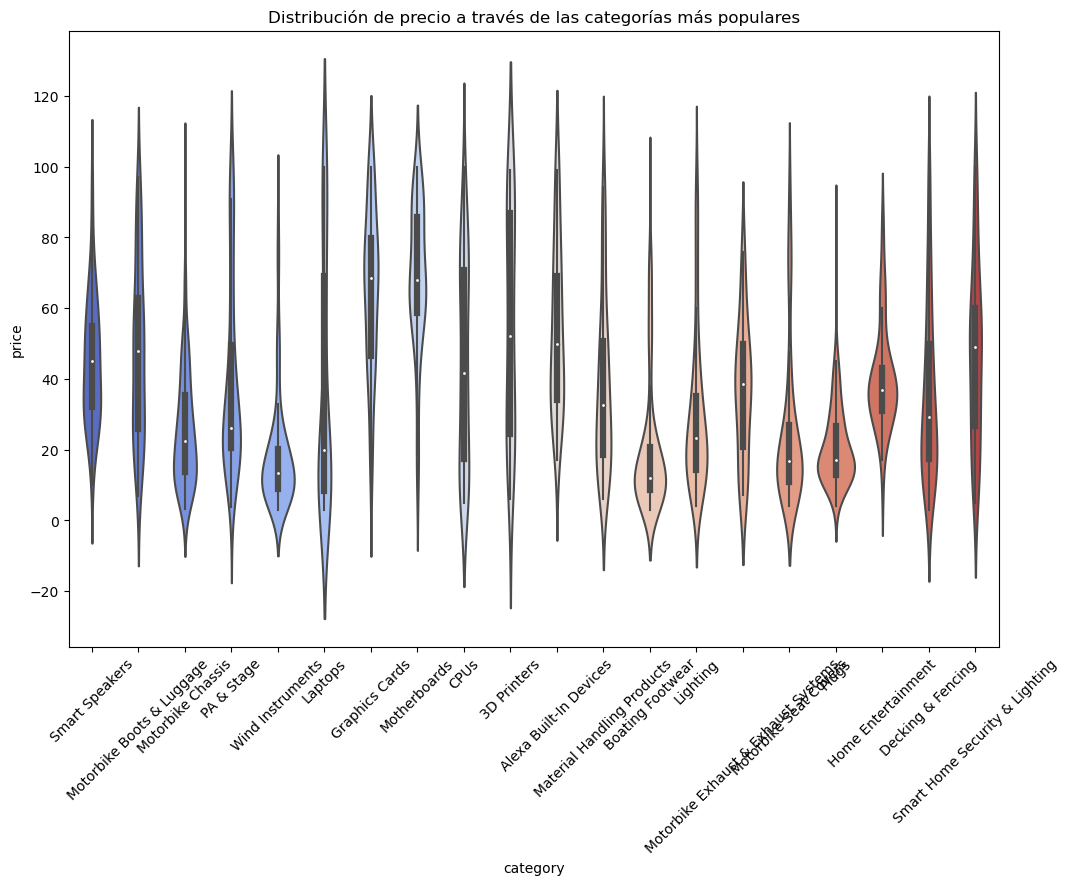

In [32]:
#Violin Plot
plt.figure(figsize=(12,8))
sns.violinplot(data=df_top_categories, x='category', y='price', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Distribución de precio a través de las categorías más populares')
plt.ylabel('price')
plt.xlabel('category')
plt.show()

In [13]:
#Identifico el producto con promedio de precio mas alto.
highest_median_category = df_sin_outliers.groupby('category')['price'].median().idxmax()
print("La categoría de producto con el precio mediano más alto:", highest_median_category)

La categoría de producto con el precio mediano más alto: Desktop PCs


2. Bar Charts:

- Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
- Which product category commands the highest average price? Don't filter here by top categories.

In [14]:
#Agrupo por categoría de producto y calcular el precio promedio
avg_price_by_category = df_sin_outliers.groupby('category')['price'].mean()

#Obtengo las 10 categorías de productos principales
top_10_categories = df_sin_outliers['category'].value_counts().nlargest(10).index

#Filtro para incluir solo las 10 categorías de productos principales
avg_price_top_10_categories = avg_price_by_category[top_10_categories]

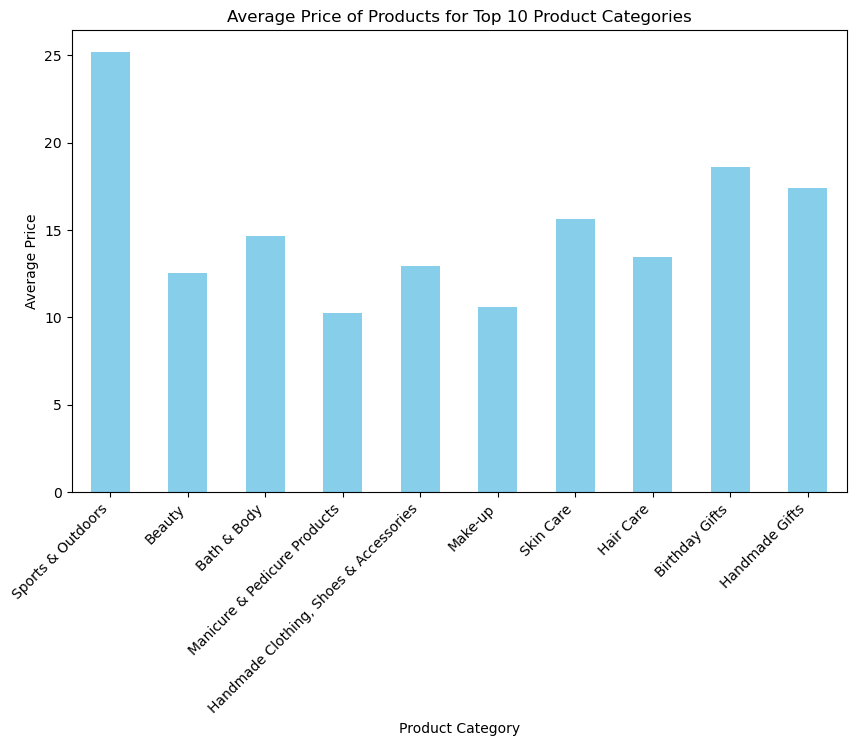

In [15]:
#Creo un Bar Chart
plt.figure(figsize=(10, 6))
avg_price_top_10_categories.plot(kind='bar', color='skyblue')
plt.title('Average Price of Products for Top 10 Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.show()

In [16]:
#Identifico la categoría de producto con el precio promedio más alto
highest_avg_price_category = avg_price_by_category.idxmax()
print("Categoría de producto con el precio promedio más alto:", highest_avg_price_category)

Categoría de producto con el precio promedio más alto: Motherboards


3. Box Plots:

- Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
- Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [17]:
#df con top 10 categorias
df_top_10_categories = df_sin_outliers[df_sin_outliers['category'].isin(top_10_categories)]

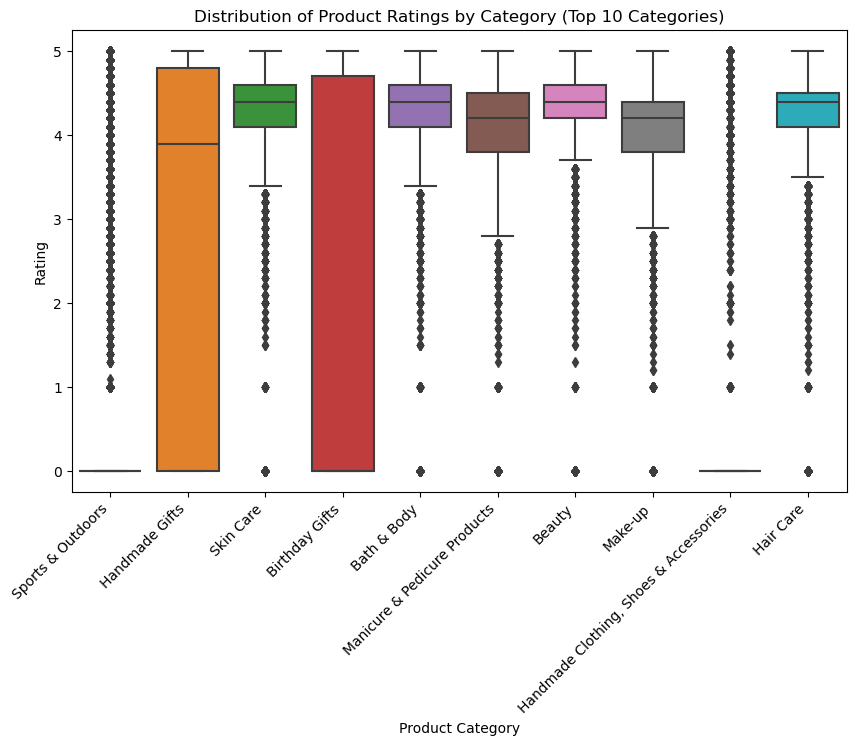

In [18]:
#side-by-side box plots
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='stars', data=df_top_10_categories)
plt.title('Distribution of Product Ratings by Category (Top 10 Categories)')
plt.xlabel('Product Category')
plt.ylabel('Rating')
plt.xticks(rotation=45, ha='right')
plt.show()

In [19]:
#Identifico la categoría que tiende a recibir la calificación mediana más alta
highest_median_rating_category = df_sin_outliers.groupby('category')['stars'].median().idxmax()
print("Categoría que tiende a recibir la calificación mediana más alta:", highest_median_rating_category)

Categoría que tiende a recibir la calificación mediana más alta: Computer Memory


Part 3: Investigating the Interplay Between Product Prices and Ratings

1. Correlation Coefficients:

- Calculate the correlation coefficient between price and stars.
- Is there a significant correlation between product price and its rating?

In [20]:
#Calculo el coeficiente de correlación
correlation_coefficient = df_sin_outliers['price'].corr(df_sin_outliers['stars'])
print("Correlation Coefficient between Price and Stars:", correlation_coefficient)

Correlation Coefficient between Price and Stars: -0.07767299878181444


In [21]:
#Pearson correlation test
corr, p_value = pearsonr(df_sin_outliers['price'], df_sin_outliers['stars'])

alpha = 0.05

if p_value < alpha:
    print("Hay una correlación significativa entre el precio del producto y su calificación.")
else:
    print("No hay una correlación significativa entre el precio del producto y su calificación.")

Hay una correlación significativa entre el precio del producto y su calificación.


2. Visualizations:

- Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
- Use a correlation heatmap to visualize correlations between all numerical variables.
- Examine if product prices typically follow a normal distribution using a QQ plot.

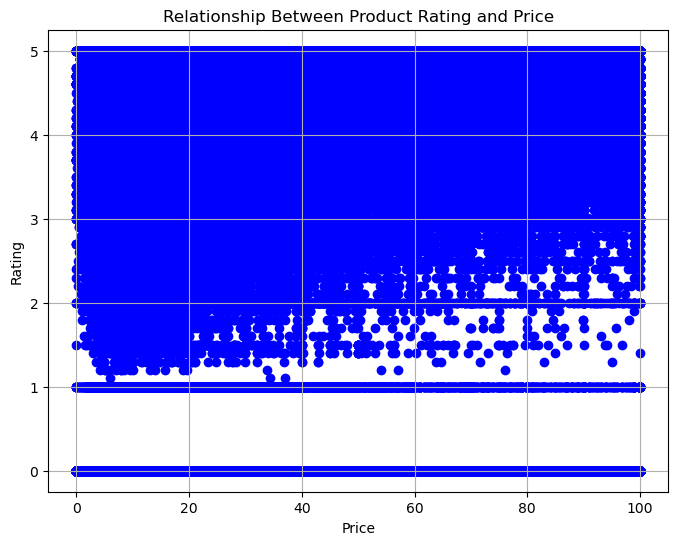

In [22]:
#Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_sin_outliers['price'], df_sin_outliers['stars'], color='blue')
plt.title('Relationship Between Product Rating and Price')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

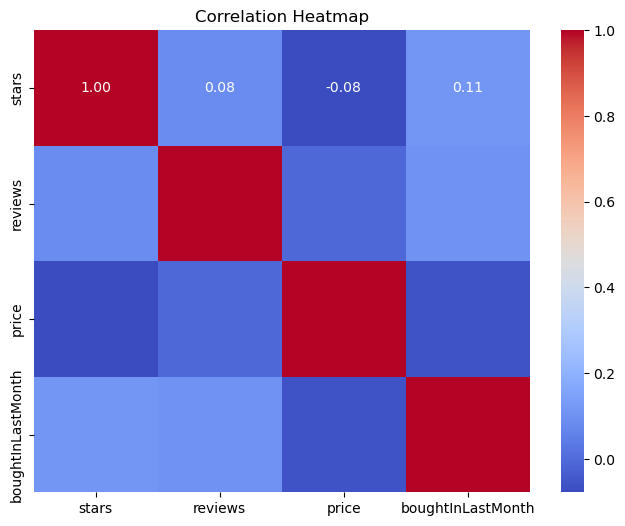

In [23]:
#Correlation Heatmap para visualizar la correlación entre las variables numericas.

numeric_columns = ['stars', 'reviews', 'price', 'boughtInLastMonth']
df_numeric = df_sin_outliers[numeric_columns].apply(pd.to_numeric, errors='coerce')

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

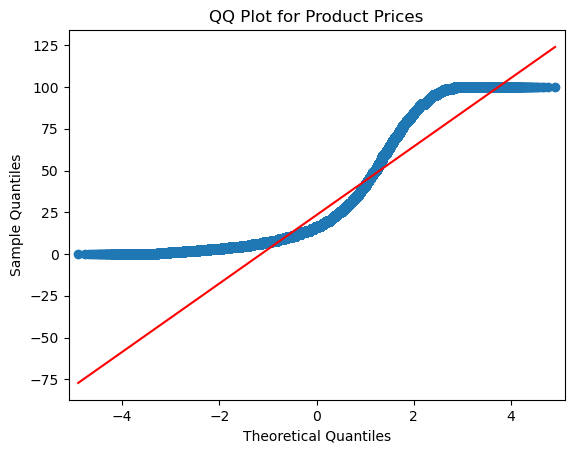

In [24]:
#QQ plot
sm.qqplot(df_sin_outliers['price'], line='s')
plt.title('QQ Plot for Product Prices')
plt.show()